In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt 
import pandas as pd
import os
from PIL import Image
from DataPreparation.CustomDataSet import CustomDataSet
from AutoEncoders.SimpleAutoencoder import AutoEncoder
import numpy as np
import pickle
from  sklearn.svm import SVC

In [2]:
from Pruning.laprune import LAP 

In [7]:
def transform(input):
    input = torch.FloatTensor(np.array(input))
    input = input.flatten()
    input = input.type(torch.FloatTensor)
    input -= torch.min(input)
    input /= torch.max(input)
    return input

In [4]:
dataset = data_set = datasets.FashionMNIST("/FashionMNIST/", download=False, transform=transform)

In [5]:
# finding the best parameters for autoencoder 
train_size = int(0.3 * len(dataset))  # int(0.3 * len(dataset)) 80% for training
validation_size = int(0.1*len(dataset))
test_size = 0.1 #len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset, _ = random_split(dataset,[0.1,0.1,0.1, 0.7])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

18000
6000


In [8]:
def train_autoencoder(model, train_loader, val_loader, epochs, lr=0.01):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()  # Set model to training mode
            total_train_loss = 0
            for X_batch, _ in train_loader:
                X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                optimizer.zero_grad()
                outputs = model(X_batch)
                train_loss = criterion(outputs, X_batch)
                train_loss.backward()
                optimizer.step()
                total_train_loss += train_loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

                # Validation
            model.eval()  # Set model to evaluation mode
            total_val_loss = 0
            with torch.no_grad():
                for X_batch, _ in val_loader:
                    X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                    outputs = model(X_batch)
                    val_loss = criterion(outputs, X_batch)
                    total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        return train_losses, val_losses

In [7]:
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.1090, Val Loss: 0.0588
Epoch 2, Train Loss: 0.0479, Val Loss: 0.0406
Epoch 3, Train Loss: 0.0370, Val Loss: 0.0336
Epoch 4, Train Loss: 0.0316, Val Loss: 0.0292
Epoch 5, Train Loss: 0.0281, Val Loss: 0.0268
Epoch 6, Train Loss: 0.0264, Val Loss: 0.0256
Epoch 7, Train Loss: 0.0253, Val Loss: 0.0245
Epoch 8, Train Loss: 0.0243, Val Loss: 0.0237
Epoch 9, Train Loss: 0.0235, Val Loss: 0.0231
Epoch 10, Train Loss: 0.0229, Val Loss: 0.0225
Epoch 11, Train Loss: 0.0224, Val Loss: 0.0221
Epoch 12, Train Loss: 0.0219, Val Loss: 0.0216
Epoch 13, Train Loss: 0.0215, Val Loss: 0.0212
Epoch 14, Train Loss: 0.0211, Val Loss: 0.0209
Epoch 15, Train Loss: 0.0208, Val Loss: 0.0206
Epoch 16, Train Loss: 0.0205, Val Loss: 0.0203
Epoch 17, Train Loss: 0.0201, Val Loss: 0.0200
Epoch 18, Train Loss: 0.0198, Val Loss: 0.0197
Epoch 19, Train Loss: 0.0195, Val Loss: 0.0194
Epoch 20, Train Loss: 0.0193, Val Loss: 0.0192
Epoch 21, Train Loss: 0.0190, Val Loss: 0.0189
Epoch 22, Train Loss: 

In [9]:
def eval_model(model, dataset, classifier):
    #model.eval()
    #criterion = nn.MSELoss()
    #total_loss = 0
    #with torch.no_grad():
     #   for X_batch, _ in data_loader:
     #       X_batch = X_batch.view(X_batch.size(0), -1)
     #       outputs = model(X_batch)
     #       loss = criterion(outputs, X_batch)
     #       total_loss += loss.item()
    #avg_loss = total_loss / len(data_loader)
    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
        for images, labels in data_loader:
            reconstructed = model(images)
            accuracy = classifier.score(reconstructed.detach().numpy(), labels)
            
            return accuracy


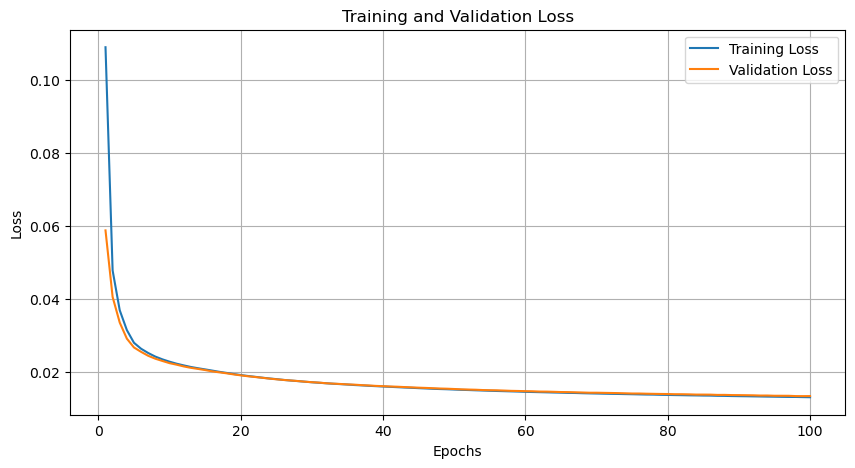

In [9]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
with open("Classifiers/CorrputedFashionMNISTClassifier_no_noise.pkl", "rb") as f:
    fashion_mnist_classifier = pickle.load(f)

In [11]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.02, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels_LAP = []  # This will store the actual sparsity levels calculated from the model
test_losses_LAP = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels_LAP.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, fashion_mnist_classifier)
    test_losses_LAP.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.02, Actual Sparsity Level: 0.0180, Test Loss: 0.8702
Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.8637
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.8667
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.8572
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.8527
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.8192
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.7635
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.4902
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.2597


In [14]:
import Pruning.ShapSAE as SSAE

In [13]:

test_data = [data for data in test_dataloader]
pruned_model = copy.deepcopy(model)
importances = SSAE.calc_importance(pruned_model,test_data[0][0])

0it [00:00, ?it/s]
100%|██████████| 8/8 [01:14<00:00,  9.35s/it]
1it [01:14, 74.82s/it]
100%|██████████| 21/21 [03:04<00:00,  8.77s/it]
3it [04:18, 87.60s/it]
 52%|█████▏    | 131/251 [18:18<16:17,  8.14s/it]divide by zero encountered in log
invalid value encountered in divide

100%|██████████| 251/251 [34:54<00:00,  8.35s/it]
5it [39:13, 470.73s/it]


In [14]:


# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.02, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []



for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, fashion_mnist_classifier)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")

5it [00:00, 714.12it/s]


Prune Ratio: 0.02, Actual Sparsity Level: 0.8082, Test Loss: 0.8100


5it [00:00, 714.39it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.3043


5it [00:00, 824.84it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.1342


5it [00:00, 1000.22it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.1130


5it [00:00, 833.13it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.1505


5it [00:00, 833.39it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.1135


5it [00:00, 1000.36it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.1592


5it [00:00, 833.29it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.1020


5it [00:00, 1000.31it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1020


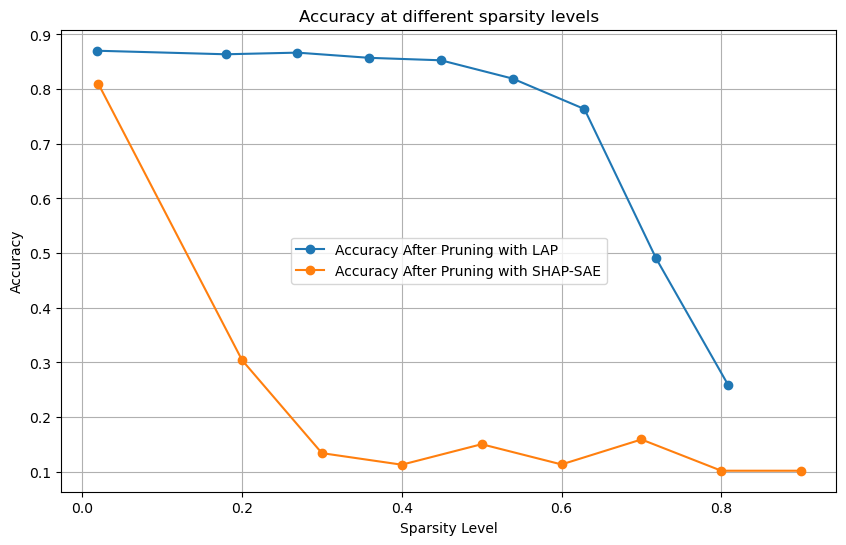

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_LAP, test_losses_LAP, '-o', label='Accuracy After Pruning with LAP')
plt.plot(prune_ratios, test_losses, '-o', label='Accuracy After Pruning with SHAP-SAE')

plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy at different sparsity levels')
plt.legend()
plt.grid(True)
plt.show()

5it [00:00, 833.03it/s]
5it [00:00, 990.30it/s]
5it [00:00, 833.39it/s]
5it [00:00, 774.74it/s]
5it [00:00, 833.63it/s]
5it [00:00, 1000.07it/s]
5it [00:00, 1000.02it/s]
5it [00:00, 988.01it/s]


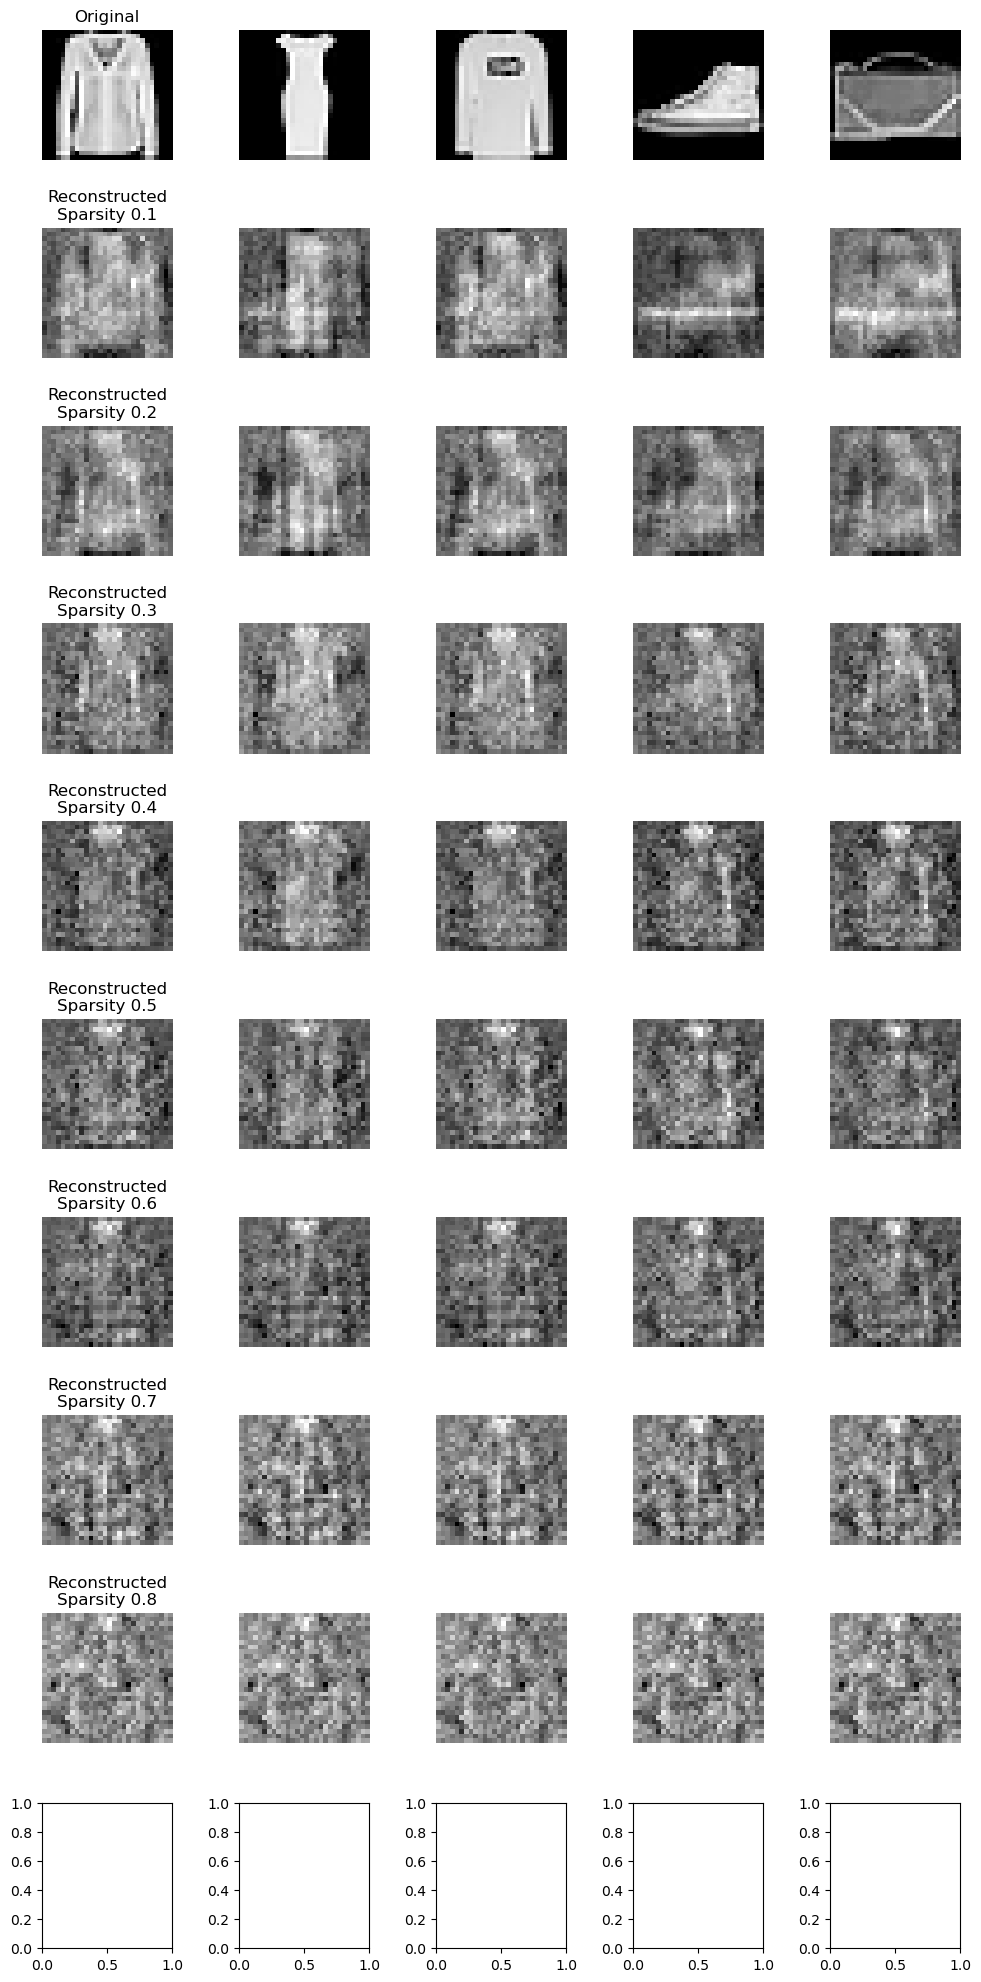

In [16]:
def display_reconstructed_images_SHAP(model, test_dataloader, importances, importance_levels):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(importance_levels, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        pruned_model, _ = SSAE.prune(pruned_model, importances, sparsity)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

display_reconstructed_images_SHAP(model, test_dataloader, importances, [0.02, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

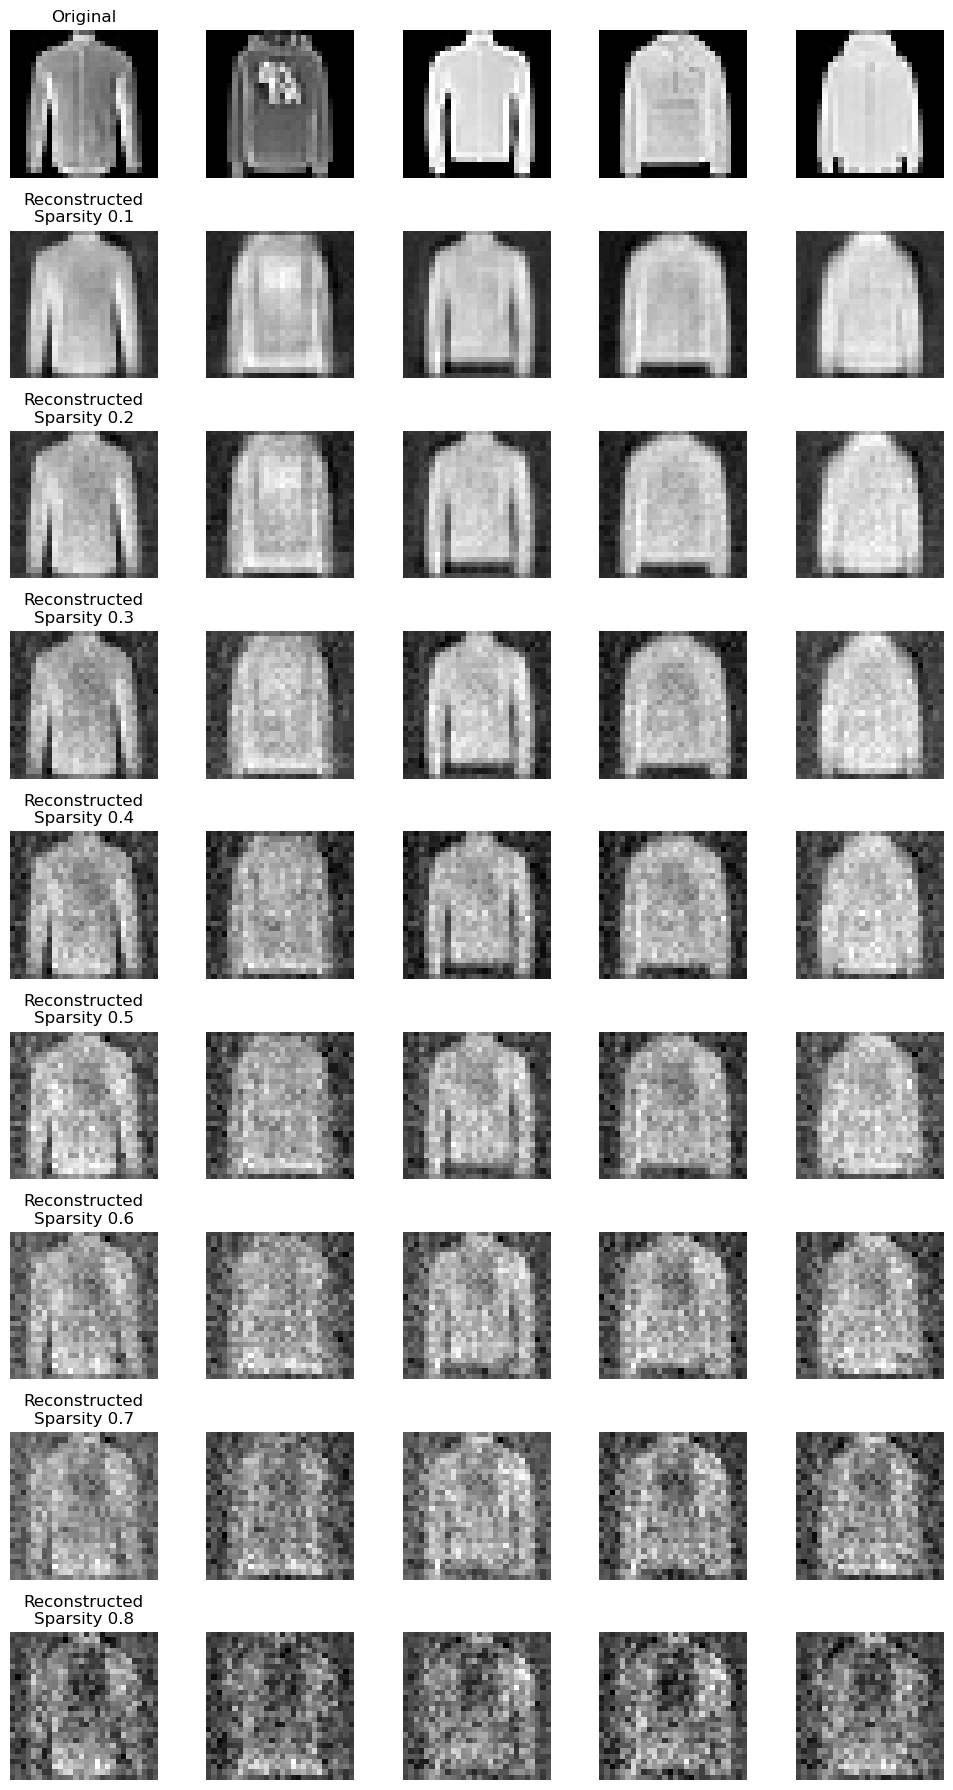

In [17]:
import matplotlib.pyplot as plt
import torch
import copy

def display_reconstructed_images(model, test_dataloader, prune_ratios):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(prune_ratios, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        apply_lap(pruned_model, [sparsity] * len(pruned_model.hidden_sizes), bn_factors=None)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

# Assuming 'model' is the trained AutoEncoder, 'test_dataloader' is defined,
# and 'prune_ratios' is a list of desired sparsity levels
display_reconstructed_images(model, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])


In [4]:
data = 'DataPreparation/CorruptedMNIST/Names.csv'
root_dir = 'DataPreparation/CorruptedMNIST'
dataset =   data_set = datasets.MNIST("./", download=False, transform=transform)

In [5]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.1*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset,_ = random_split(dataset,[0.1,0.1,0.1, 0.7])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

48000
6000


In [10]:
model_MNIST = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model_MNIST, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.0787, Val Loss: 0.0626
Epoch 2, Train Loss: 0.0563, Val Loss: 0.0474
Epoch 3, Train Loss: 0.0433, Val Loss: 0.0401
Epoch 4, Train Loss: 0.0380, Val Loss: 0.0363
Epoch 5, Train Loss: 0.0350, Val Loss: 0.0338
Epoch 6, Train Loss: 0.0327, Val Loss: 0.0318
Epoch 7, Train Loss: 0.0309, Val Loss: 0.0301
Epoch 8, Train Loss: 0.0295, Val Loss: 0.0288
Epoch 9, Train Loss: 0.0282, Val Loss: 0.0277
Epoch 10, Train Loss: 0.0270, Val Loss: 0.0266
Epoch 11, Train Loss: 0.0261, Val Loss: 0.0258
Epoch 12, Train Loss: 0.0253, Val Loss: 0.0250
Epoch 13, Train Loss: 0.0246, Val Loss: 0.0244
Epoch 14, Train Loss: 0.0239, Val Loss: 0.0237
Epoch 15, Train Loss: 0.0233, Val Loss: 0.0231
Epoch 16, Train Loss: 0.0228, Val Loss: 0.0227
Epoch 17, Train Loss: 0.0223, Val Loss: 0.0222
Epoch 18, Train Loss: 0.0219, Val Loss: 0.0218
Epoch 19, Train Loss: 0.0215, Val Loss: 0.0215
Epoch 20, Train Loss: 0.0211, Val Loss: 0.0211
Epoch 21, Train Loss: 0.0208, Val Loss: 0.0207
Epoch 22, Train Loss: 

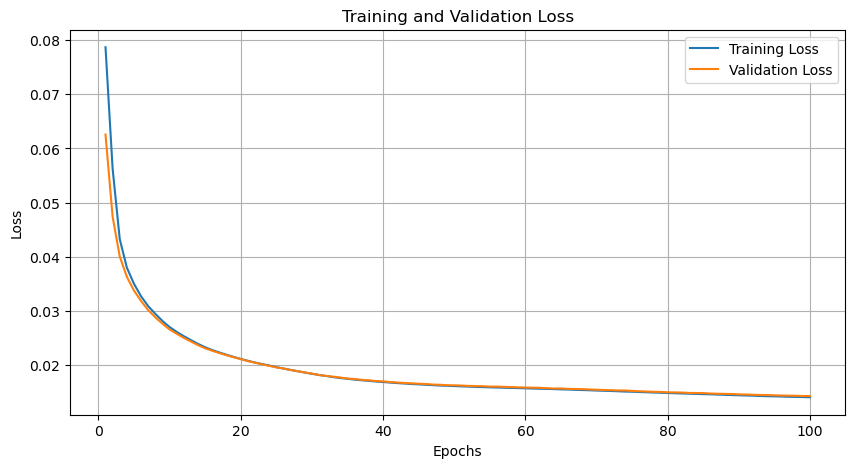

In [19]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
with open("Classifiers/MNISTClassifier_no_noise.pkl", "rb") as f:
    mnist_classifier = pickle.load(f)

In [12]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.02, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels_LAP = []  # This will store the actual sparsity levels calculated from the model
test_losses_LAP = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model_MNIST)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels_LAP.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, mnist_classifier)
    test_losses_LAP.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.02, Actual Sparsity Level: 0.0180, Test Loss: 0.9778
Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.9773
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.9770
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.9742
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.9720
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.9643
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.9273
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.7980
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.2050


In [15]:
test_data = [data for data in test_dataloader]
importances_mnist = SSAE.calc_importance(model_MNIST,test_data[0][0])

0it [00:00, ?it/s]
100%|██████████| 8/8 [01:13<00:00,  9.15s/it]
1it [01:13, 73.17s/it]
100%|██████████| 21/21 [03:03<00:00,  8.72s/it]
3it [04:16, 86.82s/it]
100%|██████████| 251/251 [34:41<00:00,  8.29s/it]
5it [38:57, 467.55s/it]


In [16]:
import Pruning.ShapSAE as SSAE

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.02, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []
pruned_model = copy.deepcopy(model_MNIST)



for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model_MNIST)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances_mnist, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, mnist_classifier)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


5it [00:00, 833.43it/s]


Prune Ratio: 0.02, Actual Sparsity Level: 0.8082, Test Loss: 0.8583


5it [00:00, 832.67it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.3422


5it [00:00, 833.63it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.1325


5it [00:00, 833.20it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.1140


5it [00:00, 714.19it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.1142


5it [00:00, 833.46it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.1138


5it [00:00, 766.84it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.1138


5it [00:00, 833.13it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.1138


5it [00:00, 775.37it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1138


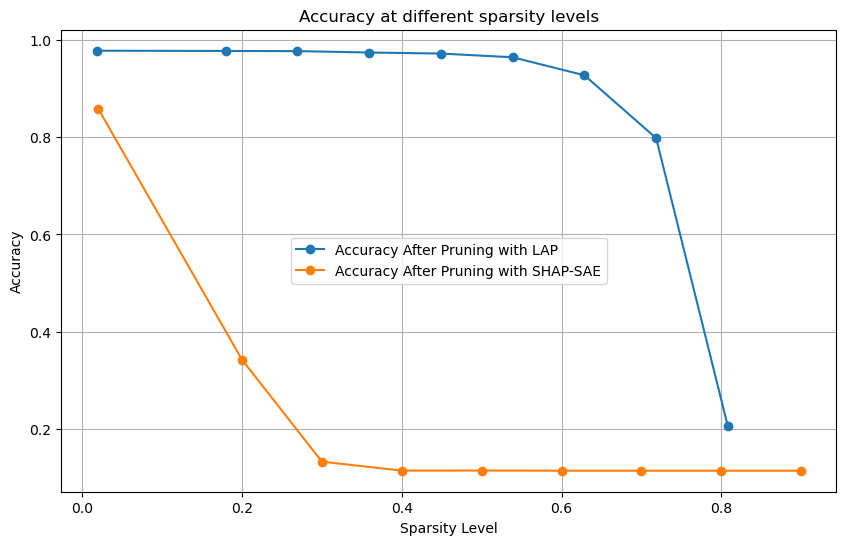

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_LAP, test_losses_LAP, '-o', label='Accuracy After Pruning with LAP')
plt.plot(prune_ratios, test_losses, '-o', label='Accuracy After Pruning with SHAP-SAE')

plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy at different sparsity levels')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
display_reconstructed_images_SHAP(model_MNIST, test_dataloader, importances, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

NameError: name 'display_reconstructed_images_SHAP' is not defined

In [ ]:
display_reconstructed_images(model_MNIST, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])